In [1]:
import gc
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

In [2]:
# optimize memory usage for key columns
dtype_dict = {
    'loan_amnt': np.float32,
    'funded_amnt': np.float32,
    'int_rate': np.float32,
}

# specify columns to parse as dates
parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

# set chunk size for large file processing
chunk_size = 500000
chunks = []

# read data in chunks to handle large file
print("Loading data in chunks...")
for chunk in pd.read_csv('accepted_2007_to_2018Q4.csv', dtype=dtype_dict, parse_dates=parse_dates, chunksize=chunk_size):
    chunks.append(chunk)

# combine chunks into a single dataframe
df = pd.concat(chunks, axis=0)

# free up memory after merging
del chunks

# confirm successful data loading
print("Data loaded successfully. Shape:", df.shape)


Loading data in chunks...


C:\Users\User\AppData\Local\Temp\ipykernel_10992\3319216911.py:13: DtypeWarning: Columns (0,19,59,118) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('accepted_2007_to_2018Q4.csv', dtype=dtype_dict, parse_dates=parse_dates, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_10992\3319216911.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for chunk in pd.read_csv('accepted_2007_to_2018Q4.csv', dtype=dtype_dict, parse_dates=parse_dates, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_10992\3319216911.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for chunk in pd.read_csv('accepted_2007_to_2018Q4.csv', dtype=dtype_dic

Data loaded successfully. Shape: (2260701, 151)


Loading a random sample of 2260000 records for EDA...


C:\Users\User\AppData\Local\Temp\ipykernel_24836\3345384033.py:17: DtypeWarning: Columns (0,19,59,118) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_24836\3345384033.py:17: DtypeWarning: Columns (0,19,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_24836\3345384033.py:17: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_24836\3345384033.py:17: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.
 

Sample loaded. Shape: (2260000, 151)
Memory usage after optimization: 5101.030285835266 MB
Missing values per column:
member_id                2260000
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
term                          33
                          ...   
settlement_status        2225763
settlement_date          2225763
settlement_amount        2225763
settlement_percentage    2225763
settlement_term          2225763
Length: 150, dtype: int64
Statistical Summary:
       member_id     loan_amnt   funded_amnt  funded_amnt_inv      int_rate  \
count        0.0  2.259967e+06  2.259967e+06     2.259967e+06  2.259967e+06   
mean         NaN  1.504687e+04  1.504161e+04     1.502338e+04  1.309270e+01   
std          NaN  9.190145e+03  9.188312e+03     9.192232e+03  4.832025e+00   
min          NaN  5.000000e+02  5.000000e+02     0.000000e+00  5.310000e+00   
25%          NaN  8.000000e+03  8.000000e+03     8.000000e+03  9.490000e+00  

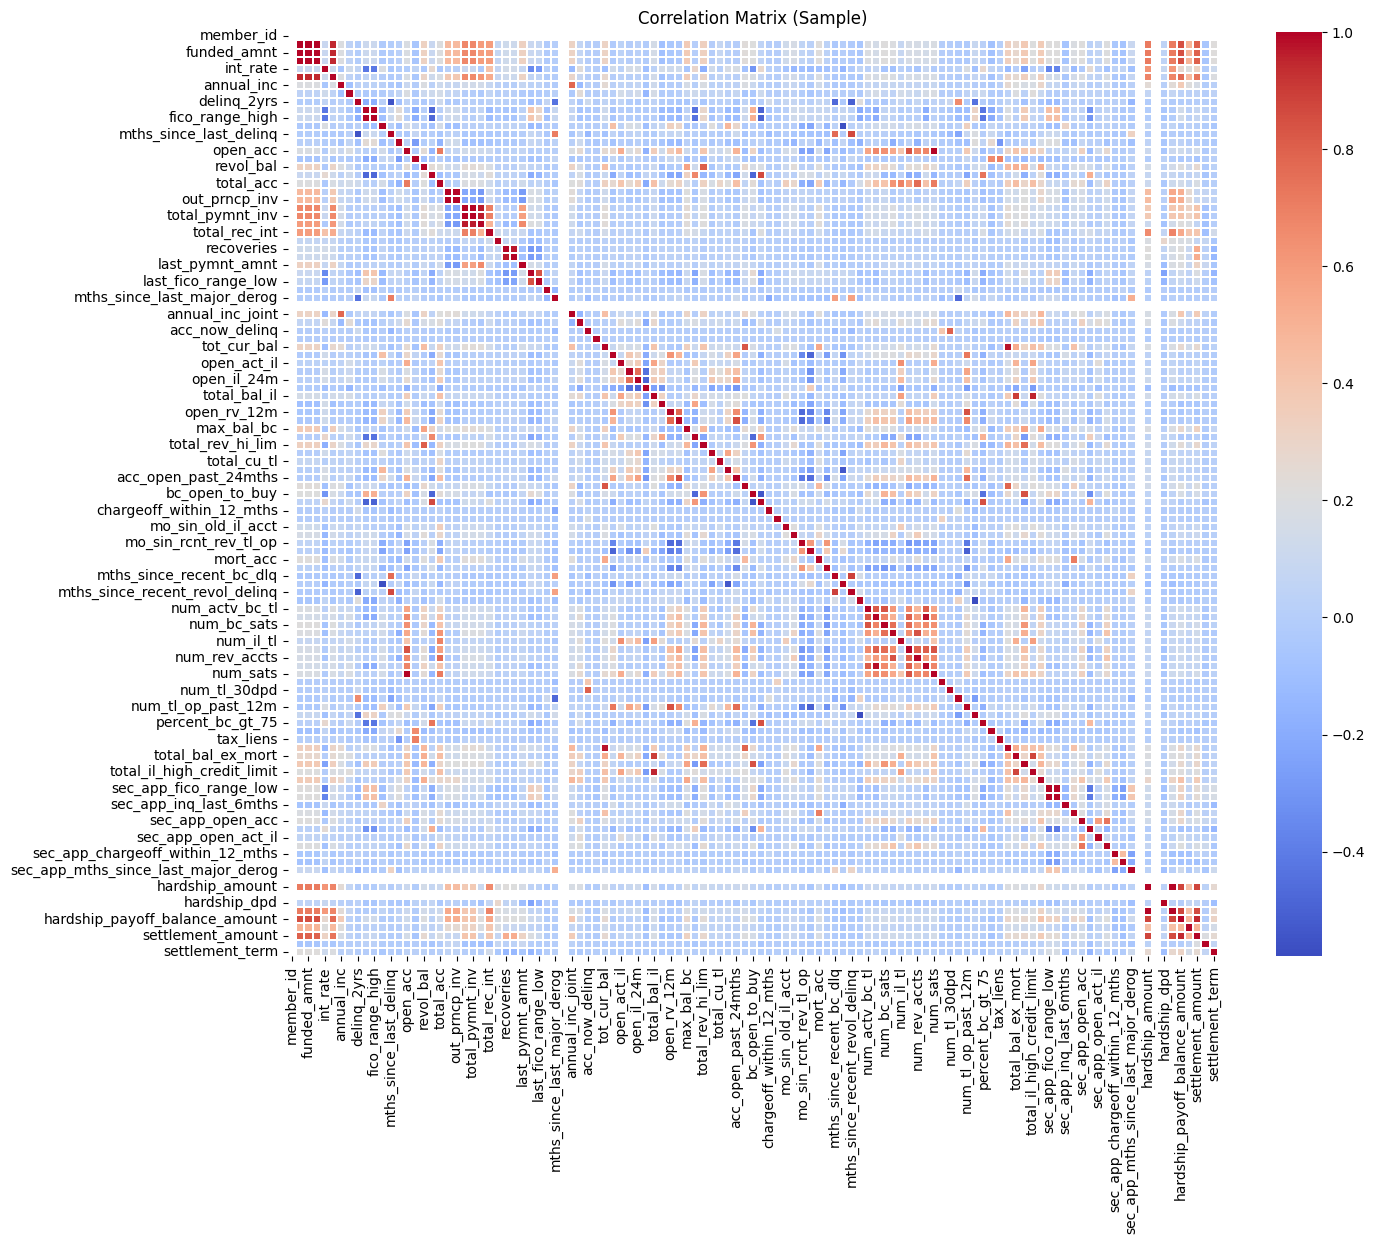

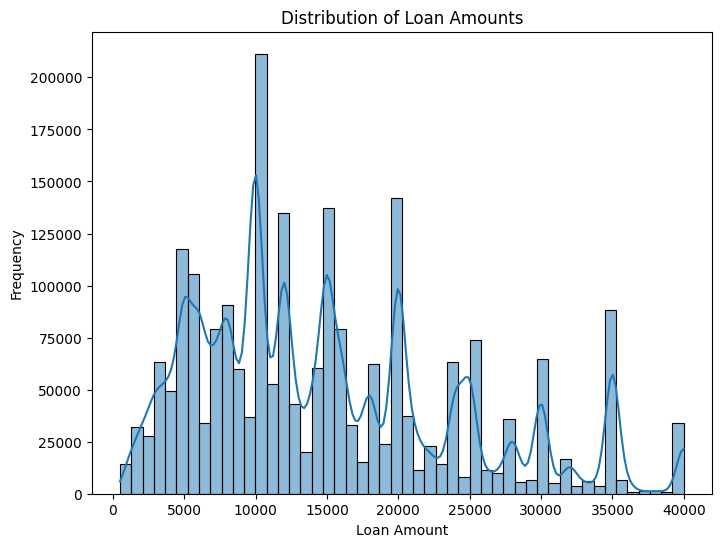

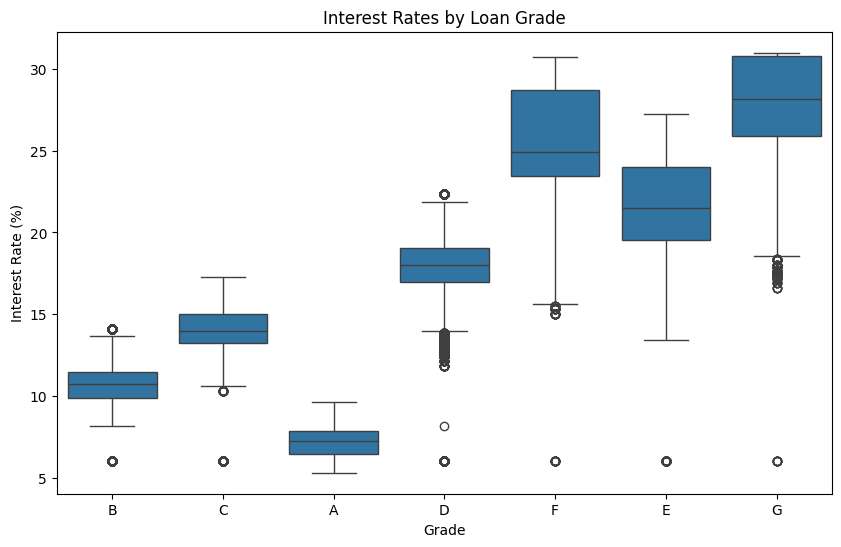

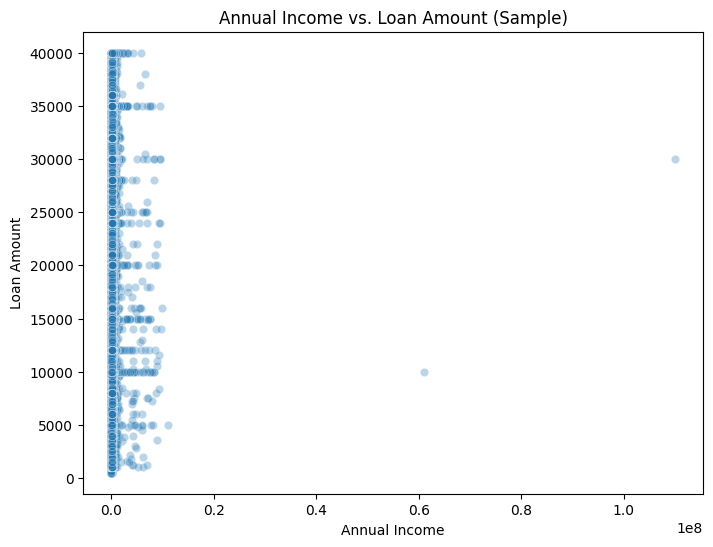

15965

In [8]:
def reduce_memory_usage(df):
    # downcast numeric columns to reduce memory usage
    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_type = df[col].dtype
        if pd.api.types.is_integer_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

def load_sample(file_path, sample_size=2260000, seed=42):
    print(f"Loading a random sample of {sample_size} records for EDA...")
    chunk_size = 500000
    chunks = []
    np.random.seed(seed)
    # load data in chunks and take a random sample
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        frac = sample_size / 2260000
        sampled_chunk = chunk.sample(frac=frac, random_state=seed)
        chunks.append(sampled_chunk)
        if len(pd.concat(chunks)) >= sample_size:
            break
    df_sample = pd.concat(chunks).head(sample_size)
    del chunks
    gc.collect()
    print(f"Sample loaded. Shape: {df_sample.shape}")
    return df_sample

file_path = 'accepted_2007_to_2018Q4.csv'

df_sample = load_sample(file_path, sample_size=2260000)

df_sample = reduce_memory_usage(df_sample)
print("Memory usage after optimization:", df_sample.memory_usage(deep=True).sum() / 1024**2, "MB")

gc.collect()

missing_values = df_sample.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# display statistical summary of the dataset
print("Statistical Summary:")
print(df_sample.describe())

numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
print(f"Calculating correlation matrix for {len(numeric_cols)} numeric columns...")
corr_matrix = df_sample[numeric_cols].corr()

# visualize the correlation matrix
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.1)
plt.title('Correlation Matrix (Sample)')
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(df_sample['loan_amnt'], bins=50, kde=True)
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amounts')
plt.show()

# plot interest rates by grade if columns exist
if 'grade' in df_sample.columns and 'int_rate' in df_sample.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='grade', y='int_rate', data=df_sample)
    plt.xlabel('Grade')
    plt.ylabel('Interest Rate (%)')
    plt.title('Interest Rates by Loan Grade')
    plt.show()
else:
    print("Columns 'grade' or 'int_rate' not found in the sample.")

# scatter plot annual income vs. loan amount if columns exist
if 'annual_inc' in df_sample.columns and 'loan_amnt' in df_sample.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='annual_inc', y='loan_amnt', data=df_sample, alpha=0.3)
    plt.xlabel('Annual Income')
    plt.ylabel('Loan Amount')
    plt.title('Annual Income vs. Loan Amount (Sample)')
    plt.show()
else:
    print("Columns 'annual_inc' or 'loan_amnt' not found in the sample.")

del df_sample
gc.collect()

In [5]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv')

threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

df.replace(['', 'NA', 'null', 'NaN', 'nan'], np.nan, inplace=True)

# function to convert employment length into integers
def emp_length_to_int(emp_length):
    if pd.isnull(emp_length) or emp_length in ['n/a', 'nan', 'NaN', 'None', '']:
        return np.nan
    emp_length = emp_length.strip()
    if emp_length == '< 1 year':
        return 0
    elif emp_length == '10+ years':
        return 10
    else:
        try:
            return int(emp_length.strip(' years').strip())
        except ValueError:
            return np.nan

# handle missing and format employment length column
if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].apply(emp_length_to_int)
    df['emp_length'] = df['emp_length'].fillna(df['emp_length'].median())

# handle missing and format the term column
if 'term' in df.columns:
    missing_term = df['term'].isnull().sum()
    print(f"Missing values in 'term': {missing_term}")
    if missing_term > 0:
        term_mode = df['term'].mode()[0]
        df['term'] = df['term'].fillna(term_mode)
        print(f"Filled missing 'term' values with mode: {term_mode}")
    df['term'] = df['term'].str.strip().str.replace(' months', '').astype(int)

# identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# convert categorical columns to strings
for col in categorical_cols:
    df[col] = df[col].astype(str)

# impute missing values in numeric columns
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

# impute missing values in categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

def percentage_to_float(x):
    if isinstance(x, str):
        return float(x.strip('%'))
    return x

# handle interest rate column
if 'int_rate' in df.columns:
    df['int_rate'] = df['int_rate'].apply(percentage_to_float)
    df['int_rate'] = df['int_rate'].astype(float)

# encode ordinal columns
ordinal_cols = ['grade', 'sub_grade']
for col in ordinal_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)
        label_enc = LabelEncoder()
        df[col] = label_enc.fit_transform(df[col])

# one-hot encode nominal columns
nominal_cols = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type', 'initial_list_status']
nominal_cols = [col for col in nominal_cols if col in df.columns]
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# rescale numeric columns
scaler = MinMaxScaler()
scaled_cols = ['loan_amnt', 'annual_inc', 'dti', 'revol_util', 'emp_length', 'term']
scaled_cols = [col for col in scaled_cols if col in df.columns]
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

# create a feature for installment to income ratio
if 'installment' in df.columns and 'annual_inc' in df.columns:
    df['installment_to_income_ratio'] = df['installment'] / (df['annual_inc'] + 1e-8)

# simplify loan status into binary values
def simplify_loan_status(status):
    if status in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)']:
        return 1
    elif status in ['Fully Paid', 'Current']:
        return 0
    else:
        return np.nan

if 'loan_status' in df.columns:
    df['loan_status_binary'] = df['loan_status'].apply(simplify_loan_status)
    df = df.dropna(subset=['loan_status_binary'])
    df['loan_status_binary'] = df['loan_status_binary'].astype(int)
else:
    raise ValueError("Column 'loan_status' not found in the dataset.")

# drop irrelevant columns
irrelevant_cols = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'emp_title', 'issue_d']
df = df.drop(columns=irrelevant_cols, errors='ignore')

X = df.drop(['loan_status', 'loan_status_binary'], axis=1, errors='ignore')
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns in X:", non_numeric_cols)

X = X.drop(columns=non_numeric_cols)

y = df['loan_status_binary']

print("Data types after preprocessing:")
print(X.dtypes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


C:\Users\User\AppData\Local\Temp\ipykernel_24836\56845607.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('accepted_2007_to_2018Q4.csv')


Missing values in 'term': 33
Filled missing 'term' values with mode:  36 months
Non-numeric columns in X: ['pymnt_plan', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'home_ownership_nan', 'verification_status_Source Verified', 'verification_status_Verified', 'verification_status_nan', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_nan', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr

In [6]:
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1)
lr_model.fit(X_train, y_train)

print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1, n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

Training Logistic Regression model...
Training Random Forest Classifier...
Training XGBoost Classifier...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Evaluating Logistic Regression model...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    391014
           1       1.00      0.88      0.94     58883

    accuracy                           0.98    449897
   macro avg       0.99      0.94      0.96    449897
weighted avg       0.98      0.98      0.98    449897

AUC-ROC Score for Logistic Regression: 0.9617061619826223

Evaluating Random Forest model...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    391014
           1       1.00      0.86      0.92     58883

    accuracy                           0.98    449897
   macro avg       0.99      0.93      0.96    449897
weighted avg       0.98      0.98      0.98    449897

AUC-ROC Score for Random Forest: 0.9915883635658884

Evaluating XGBoost model...
Classification Report for XGBoost:
         

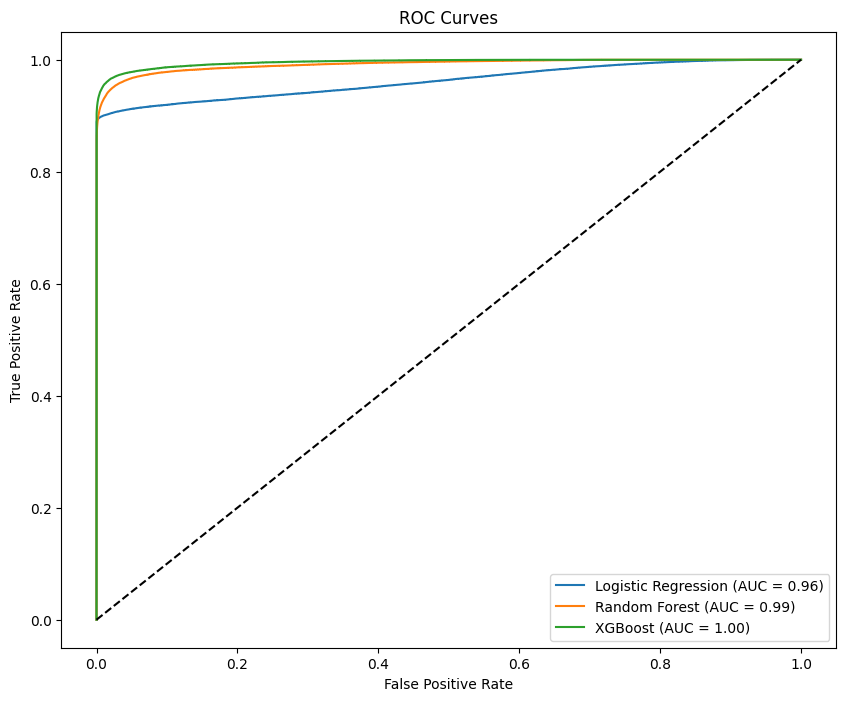

In [7]:
# evaluate logistic regression model
print("Evaluating Logistic Regression model...")
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:,1]

# display classification report for logistic regression
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

# calculate and display AUC-ROC score for logistic regression
lr_auc = roc_auc_score(y_test, y_pred_prob_lr)
print("AUC-ROC Score for Logistic Regression:", lr_auc)

# evaluate random forest model
print("\nEvaluating Random Forest model...")
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:,1]

# display classification report for random forest
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# calculate and display AUC-ROC score for random forest
rf_auc = roc_auc_score(y_test, y_pred_prob_rf)
print("AUC-ROC Score for Random Forest:", rf_auc)

# evaluate xgboost model
print("\nEvaluating XGBoost model...")
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

# display classification report for xgboost
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# calculate and display AUC-ROC score for xgboost
xgb_auc = roc_auc_score(y_test, y_pred_prob_xgb)
print("AUC-ROC Score for XGBoost:", xgb_auc)

# plot ROC curves for all models
plt.figure(figsize=(10,8))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % lr_auc)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % rf_auc)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % xgb_auc)

# add diagonal reference line
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


Central Tendency Measures:
Mean Loan Amount: $15,046.93
Median Annual Income: $65,000.00
Mean Interest Rate: 13.09%
Standard Deviation of Debt-to-Income Ratio (DTI): 14.18

Correlation Analysis:

Positive Correlations:
loan_amnt and annual_inc: 0.20
loan_amnt and int_rate: 0.10
loan_amnt and dti: 0.04
loan_amnt and fico_range_high: 0.11
annual_inc and loan_amnt: 0.20
annual_inc and fico_range_high: 0.04
int_rate and loan_amnt: 0.10
int_rate and dti: 0.12
dti and loan_amnt: 0.04
dti and int_rate: 0.12
fico_range_high and loan_amnt: 0.11
fico_range_high and annual_inc: 0.04

Negative Correlations:
annual_inc and int_rate: -0.05
annual_inc and dti: -0.08
int_rate and annual_inc: -0.05
int_rate and fico_range_high: -0.42
dti and annual_inc: -0.08
dti and fico_range_high: -0.03
fico_range_high and int_rate: -0.42
fico_range_high and dti: -0.03


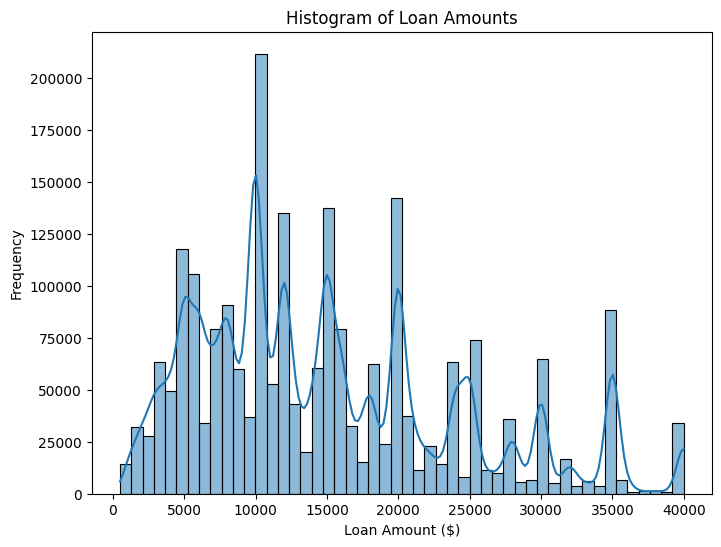

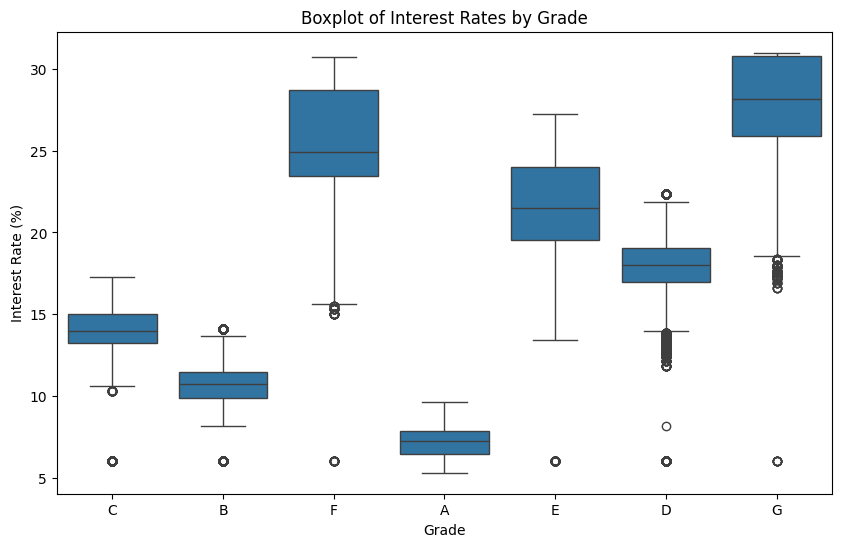

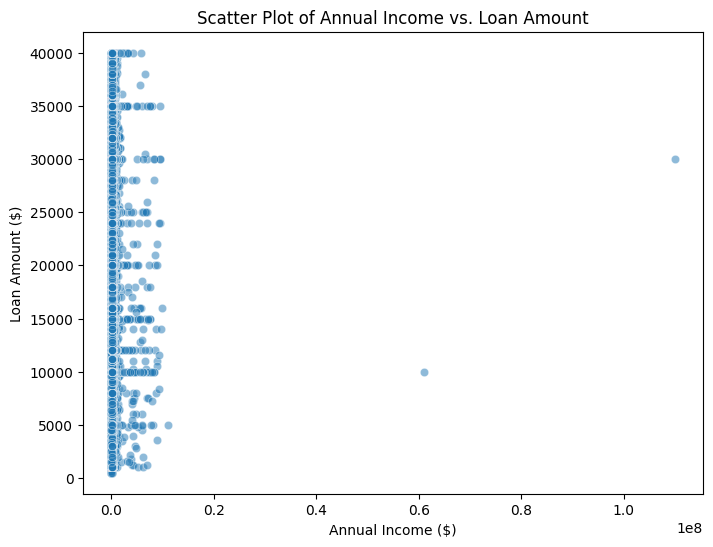


Insights:
- The histogram shows a right-skewed distribution, indicating most loans are smaller amounts.
- The boxplot shows increasing interest rates with lower loan grades.
- The scatter plot reveals a positive trend between annual income and loan amount, with significant variance.
- The correlation analysis suggests that borrowers with higher incomes tend to request larger loans, and borrowers with higher debt-to-income ratios are charged higher interest rates.
- Borrowers with higher credit scores receive lower interest rates.


In [4]:
#for report part only
required_columns = ['loan_amnt', 'annual_inc', 'int_rate', 'dti', 'fico_range_high', 'grade']

for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing from the dataset. Please check your data.")

mean_loan_amount = df['loan_amnt'].mean()
median_annual_income = df['annual_inc'].median()
mean_interest_rate = df['int_rate'].mean()
std_dti = df['dti'].std()

print(f"Central Tendency Measures:")
print(f"Mean Loan Amount: ${mean_loan_amount:,.2f}")
print(f"Median Annual Income: ${median_annual_income:,.2f}")
print(f"Mean Interest Rate: {mean_interest_rate:.2f}%")
print(f"Standard Deviation of Debt-to-Income Ratio (DTI): {std_dti:.2f}\n")

correlation_matrix = df[['loan_amnt', 'annual_inc', 'int_rate', 'dti', 'fico_range_high']].corr()

print("Correlation Analysis:")
positive_corr = correlation_matrix[(correlation_matrix > 0) & (correlation_matrix < 1)].stack()
negative_corr = correlation_matrix[(correlation_matrix < 0)].stack()

print("\nPositive Correlations:")
for (row, col), value in positive_corr.items():
    print(f"{row} and {col}: {value:.2f}")

print("\nNegative Correlations:")
for (row, col), value in negative_corr.items():
    print(f"{row} and {col}: {value:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(df['loan_amnt'], bins=50, kde=True)
plt.title('Histogram of Loan Amounts')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='int_rate', data=df)
plt.title('Boxplot of Interest Rates by Grade')
plt.xlabel('Grade')
plt.ylabel('Interest Rate (%)')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='annual_inc', y='loan_amnt', data=df, alpha=0.5)
plt.title('Scatter Plot of Annual Income vs. Loan Amount')
plt.xlabel('Annual Income ($)')
plt.ylabel('Loan Amount ($)')
plt.show()

print("\nInsights:")
print("- The histogram shows a right-skewed distribution, indicating most loans are smaller amounts.")
print("- The boxplot shows increasing interest rates with lower loan grades.")
print("- The scatter plot reveals a positive trend between annual income and loan amount, with significant variance.")
print("- The correlation analysis suggests that borrowers with higher incomes tend to request larger loans, and borrowers with higher debt-to-income ratios are charged higher interest rates.")
print("- Borrowers with higher credit scores receive lower interest rates.")
